## 1. Data Preprocessing

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import ast
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import tqdm
sns.set_style('darkgrid')

In [1]:
chunks = pd.read_json('Books.json', lines=True, chunksize =1000000)
result=pd.DataFrame()
for c in tqdm.tqdm_notebook(chunks):
    result=result.append(c[['reviewerID','overall','asin']])
result.to_csv('Books.csv',index=False)

In [4]:
chunks = pd.read_json('Movies_and_TV.json', lines=True, chunksize =1000000)
result=pd.DataFrame()
for c in tqdm.tqdm_notebook(chunks):
    result=result.append(c[['reviewerID','overall','asin']])
result.to_csv('movies_and_tv.csv',index=False)

In [1]:
bookdf=pd.read_csv('Books.csv')
motvdf=pd.read_csv('movies_and_tv.csv')
motvid=set(motvdf['reviewerID'])
bookdf=bookdf[bookdf.reviewerID.isin(motvid)]
bookdf_grouped=bookdf.groupby('reviewerID')
motvdf_grouped=motvdf.groupby('reviewerID')

In [4]:
bookdf_overall=bookdf_grouped['overall'].apply(list)
motvdf_overall=motvdf_grouped['overall'].apply(list)
merged=pd.merge(pd.DataFrame(motvdf_overall),pd.DataFrame(bookdf_overall),on='reviewerID')
merged.columns=['movies','books']
merged.to_csv('merged.csv')
merged2=merged[merged['movies'].apply(lambda x:len(x)>=5) & merged['books'].apply(lambda x:len(x)>=5)]
merged2.to_csv('merged2.csv')

In [116]:
bookdf_overall=bookdf_grouped['asin'].apply(list)
motvdf_overall=motvdf_grouped['asin'].apply(list)
merged=pd.merge(pd.DataFrame(motvdf_overall),pd.DataFrame(bookdf_overall),on='reviewerID')
merged.columns=['movies','books']
merged.to_csv('merged_asin.csv')
merged2=merged[merged['movies'].apply(lambda x:len(x)>=5) & merged['books'].apply(lambda x:len(x)>=5)]
merged2.to_csv('merged2_asin.csv')

## 2. Question 2

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ast
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import tqdm
sns.set_style('darkgrid')

In [2]:
merged2=pd.read_csv('merged2.csv',converters={1:ast.literal_eval,2:ast.literal_eval})

In [3]:
merged2.head()

,reviewerID,movies,books
0,A0072041HVZ3465DXUOR,"[5, 5, 5, 5, 5, 5, 5]","[5, 5, 5, 5, 3, 5, 5]"
1,A0113687U6BI6AIBOQDK,"[5, 5, 5, 5, 5, 4]","[5, 5, 5, 5, 5, 5, 5, 5, 5]"
2,A0160612BLIWRHROHLLE,"[5, 5, 4, 5, 1, 4, 5]","[5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 5, 4, 5, 5, ..."
3,A0261335MGUP6K91KAAP,"[5, 5, 5, 5, 5]","[4, 5, 5, 5, 5, 4]"
4,A0275782DY4RT0D8KADG,"[5, 5, 5, 5, 5, 5, 5]","[5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [6]:
merged2.shape

(133103, 3)

In [7]:
merged2['movies_5_ratio']=[sum(np.array(x)==5)/len(x) for x in merged2['movies']]
merged2['books_5_ratio']=[sum(np.array(x)==5)/len(x) for x in merged2['books']]
merged2['movies_ext_ratio']=[sum(pd.Series(x).isin([1,5]))/len(x) for x in merged2['movies']]
merged2['books_ext_ratio']=[sum(pd.Series(x).isin([1,5]))/len(x) for x in merged2['books']]
merged2['movies_mean']=[np.mean(x) for x in merged2['movies']]
merged2['books_mean']=[np.mean(x) for x in merged2['books']]

In [8]:
merged2['diff_5_ratio']=merged2['movies_5_ratio']-merged2['books_5_ratio']
merged2['diff_ext_ratio']=merged2['movies_ext_ratio']-merged2['books_ext_ratio']
merged2['diff_mean']=merged2['movies_mean']-merged2['books_mean']

In [9]:
zipped=list(zip(merged2['movies'],merged2['books']))
result=[]
for x in tqdm.tqdm_notebook(zipped):
    if np.mean(x[0])!=np.mean(x[1]):
        result.append(stats.ttest_ind(x[0],x[1]).pvalue)
    else:
        result.append(1)
merged2['ttest']=result        
tt_ratio=sum(merged2['ttest']<0.05)/len(merged2)
print(tt_ratio) #We can reject the null hypothesis that the mean of reviews between Movies/TV and Books are the same for 15% of reviewers
merged2.to_csv('merged3.csv',index=False)


0.15024454745572977


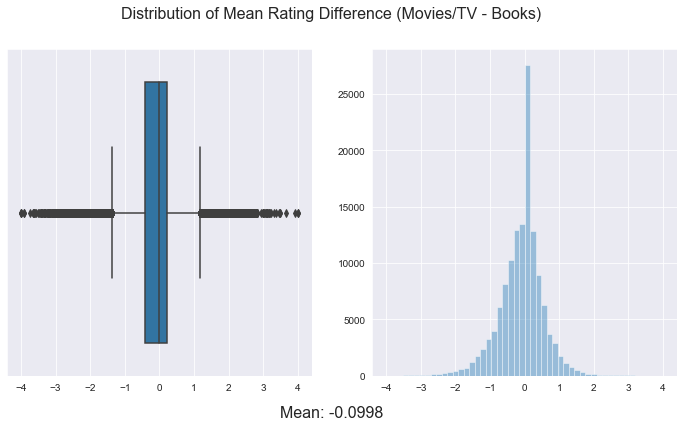

In [10]:
fig, ax =plt.subplots(1,2,figsize=(12,6))
plot=sns.boxplot(merged2['diff_mean'], ax=ax[0])
plot.set(xlabel=None)
plot=sns.distplot(merged2['diff_mean'], ax=ax[1],kde=False)
plot.set(xlabel=None)
meanval=round(np.mean(merged2['diff_mean']),4)
fig.suptitle(f"Distribution of Rating Mean Difference (Movies/TV - Books)", fontsize=16)
fig.text(0.5,0.04, f"Mean: {meanval}", ha="center", va="center",fontsize=16)

plt.show()

<li> For each reviewerID, mean rating for movies/tv and books were calculated. Then, the difference of these means were calculated by subtracting movies/tv mean rating from books mean rating. The mean was -0.0998, which indicates that the reviewers are slightly more genourus when rating the books. 

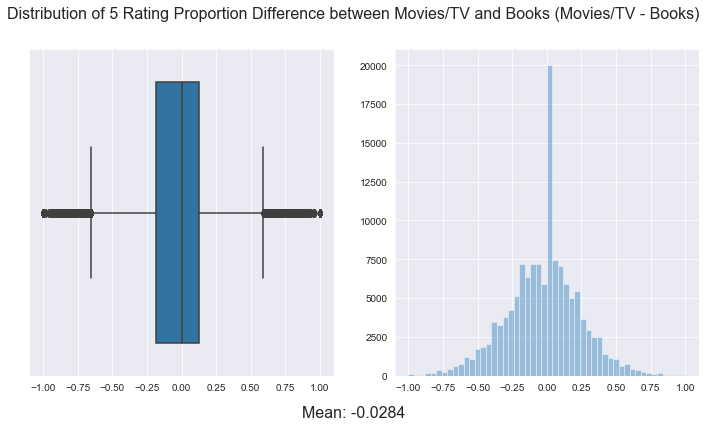

In [7]:
fig, ax =plt.subplots(1,2,figsize=(12,6))
plot=sns.boxplot(merged2['diff_5_ratio'], ax=ax[0])
plot.set(xlabel=None)
plot=sns.distplot(merged2['diff_5_ratio'], ax=ax[1],kde=False)
plot.set(xlabel=None)
meanval=round(np.mean(merged2['diff_5_ratio']),4)
fig.suptitle(f"Distribution of 5 Rating Proportion Difference (Movies/TV - Books)", fontsize=16)
fig.text(0.5,0.04, f"Mean: {meanval}", ha="center", va="center",fontsize=16)

plt.show()

<li>For each revier ID, the proportion of 5 rating for movies/tv and books were calculated. Then, the differcne of these proportions were calculated by subtracting movies/tv proportion from books proportion. The mean was -0.0284, which indicates that the reviewers tend to give 5 ratings more to the books when compared to movies/tv, although the difference is marginal.
    

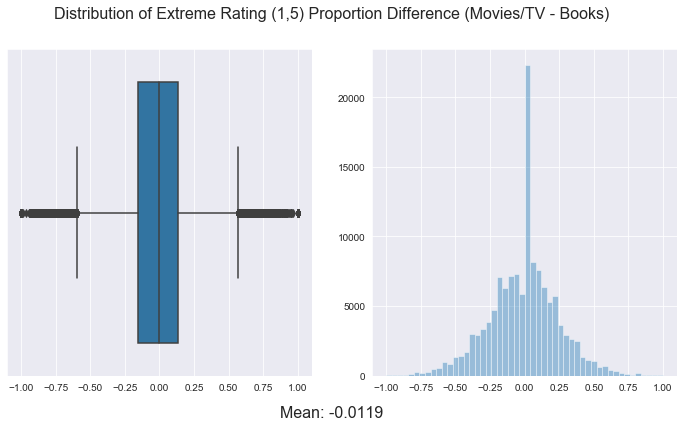

In [10]:
fig, ax =plt.subplots(1,2,figsize=(12,6))
plot=sns.boxplot(merged2['diff_ext_ratio'], ax=ax[0])
plot.set(xlabel=None)
plot=sns.distplot(merged2['diff_ext_ratio'], ax=ax[1],kde=False)
plot.set(xlabel=None)
meanval=round(np.mean(merged2['diff_ext_ratio']),4)
fig.suptitle(f"Distribution of Extreme Rating (1,5) Proportion Difference (Movies/TV - Books)", fontsize=16)
fig.text(0.5,0.04, f"Mean: {meanval}", ha="center", va="center",fontsize=16)
plt.show()

<li>Extreme ratings, which were defined as ratings with 1 and 5, were analyzed in the similar manner as previous analysis. The mean was -0.0119, which indicates that the reviewers ten to give extreme ratings more to the books when compared to movies/tv, although the difference is marginal. 

## 3. Question 3

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ast
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pandas as pd
import tqdm
sns.set_style('darkgrid')

In [ ]:

chunks = pd.read_json('meta_Movies_and_TV.json', lines=True, chunksize =1000000)

result=pd.DataFrame()

for c in tqdm.tqdm_notebook(chunks):

    result=result.append(c[['asin','title']])
result.to_csv('movies_and_tv_title.csv',index=False)

In [2]:

chunks = pd.read_json('meta_Books.json', lines=True, chunksize =100000)
    
result=pd.DataFrame()

for c in tqdm.tqdm_notebook(chunks):

    result=result.append(c[['asin','title']])
result.to_csv('books_title.csv',index=False)

In [3]:
books_title=pd.read_csv('books_title.csv')
motv_title=pd.read_csv('movies_and_tv_title.csv')

In [49]:
result=[]
for books in tqdm.tqdm_notebook(books_title['title']):
    result.append(fuzz.ratio(str(motv_title['title'][0]),str(books)))

In [60]:
motv_title['title'][0]

'Understanding Seizures and Epilepsy'

In [59]:
books_title['title'][np.argmax(result)]

'Understanding Serenity'